In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Dataset

In [313]:
#@title Load the dataset

words1 = open('mkd_names_1.txt', 'r').read().splitlines()
words2 = open('mkd_names_2.txt', 'r').read().splitlines()

words1 = [x.lower() if isinstance(x, str) else x for x in words1]
words2 = [x.lower() if isinstance(x, str) else x for x in words2]

words2_new = [w.split()[0] for w in words2]

words = words1 + words2_new
words = list(dict.fromkeys(words))  # list(set(words))

In [314]:
#@title Vocabulary

# Build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [315]:
#@title Build dataset

block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]  # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(123)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])    # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte,  Yte  = build_dataset(words[n2:])    # 10%

torch.Size([2022, 3]) torch.Size([2022])
torch.Size([258, 3]) torch.Size([258])
torch.Size([247, 3]) torch.Size([247])


# Backpropagation Ninja

In [316]:
# Utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact {str(ex):5s} | approximate {str(app):5s} | maxdiff {maxdiff}')

In [317]:
VOCAB_SIZE = 30 + 1
EMBED_SIZE = 10  # the dimensionality of the character embedding vectors
HIDDEN_SIZE = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(123) # for reproducibility
C  = torch.randn((VOCAB_SIZE, EMBED_SIZE),               generator=g)
# Layer 1
W1 = torch.randn((EMBED_SIZE * block_size, HIDDEN_SIZE), generator=g) * ((5/3) / ((EMBED_SIZE * block_size)**0.5))
b1 = torch.randn(HIDDEN_SIZE,                            generator=g) * 0.1  # it's useless because of BatchNorm, but let's still use it
# Layer 2
W2 = torch.randn((HIDDEN_SIZE, VOCAB_SIZE),              generator=g) * 0.1
b2 = torch.randn(VOCAB_SIZE,                             generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, HIDDEN_SIZE), generator=g) * 0.1 + 1.0
bnbias = torch.randn((1, HIDDEN_SIZE), generator=g) * 0.1

# Note: We are initializing the parameters in a non-standard ways,
# because sometimes initializing with e.g. all zeros could mask an
# incorrect implementation of the backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
  p.requires_grad = True

13141


In [318]:
batch_size = 32
n = batch_size  # A shorter variable name also, for convenience
# Construct a mini-batch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]  # Batch X, Y

In [319]:
# Forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb]  # Embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)  # Concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1  # Hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True)  # Note: Bessel's correction
bnvar_inv = (bnvar + 1e-5)**(-0.5)
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)  # Hidden layer
# Linear layer 2
logits = h @ W2 + b2  # Output layer
# Cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**(-1)  # If we use 1.0/counts_sum instead, we can't use backprop to be bit exact
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
          t.retain_grad()
loss.backward()
loss

tensor(4.1324, grad_fn=<NegBackward0>)

# Exercise 1

Backprop through the whole thing manually, backpropagating through exactly all the variables as they are defined in the forward pass above, one by one.

## dlogprobs

In [153]:
logprobs.shape

torch.Size([32, 31])

The derivative of the loss with respect to logprobs shall have the same shape: (BATCH_SIZE, VOCABULARY_SIZE).

In [154]:
logprobs[range(n), Yb].shape

torch.Size([32])

loss = -(1/3) * (a + b + c)

dloss/da = -1/3 or -1/n in general

In [155]:
# loss = -logprobs[range(n), Yb].mean()
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact True  | approximate True  | maxdiff 0.0


In [156]:
dlogprobs.shape

torch.Size([32, 31])

## dprobs

In [157]:
probs.shape

torch.Size([32, 31])

In [158]:
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# y = log(x)
# dy/dx = 1/x

# dloss/dprobs = dloss/dlogprobs * dlogprobs/dprobs
dprobs = dlogprobs * probs**(-1)
dprobs.shape

torch.Size([32, 31])

In [159]:
cmp('probs', dprobs, probs)

probs           | exact True  | approximate True  | maxdiff 0.0


## dcounts_sum_inv

In [160]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 31]), torch.Size([32, 1]))

In [161]:
# dloss/counts_sum_inv = dloss/dlogprobs * dlogprobs/dprobs * dprobs/dcounts_sum_inv
# dloss/counts_sum_inv = dloss/dprobs * * dprobs/dcounts_sum_inv
# probs = counts * counts_sum_inv
# Here it's tricky because also broadcasting is applied, to allow for (32, 31) x (32, 1).
# So, it's not just multiplication, but two operations in one.

dcounts_sum_inv = (dprobs * counts).sum(dim=1, keepdim=True)
dcounts_sum_inv.shape

torch.Size([32, 1])

In [162]:
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact True  | approximate True  | maxdiff 0.0


## dcounts_sum

In [163]:
counts_sum.shape

torch.Size([32, 1])

In [164]:
# dloss/dcounts_sum = dloss/dcounts_sum_inv * dcounts_sum_inv/dcounts_sum
# counts_sum_inv = counts_sum**(-1)

dcounts_sum = dcounts_sum_inv * (-1) * counts_sum**(-2)
dcounts_sum.shape

torch.Size([32, 1])

In [165]:
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact True  | approximate True  | maxdiff 0.0


## dcounts

In [166]:
counts.shape, counts.shape

(torch.Size([32, 31]), torch.Size([32, 31]))

In [167]:
# dloss/dcounts = dloss/dprobs * dprobs/dcounts + dloss/dcounts_sum * dcounts_sum/dcounts

# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdim=True)
# counts_sum_inv = counts_sum**(-1)  # If we use 1.0/counts_sum instead, we can't use backprop to be bit exact
# probs = counts * counts_sum_inv

dcounts = dprobs * counts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dcounts.shape

torch.Size([32, 31])

In [168]:
cmp('counts', dcounts, counts)

counts          | exact True  | approximate True  | maxdiff 0.0


This calculation is incomplete, because counts has a second contribution, i.e., a second branch.

 ## dnorm_logits

In [169]:
norm_logits.shape

torch.Size([32, 31])

In [170]:
# counts = norm_logits.exp()

# y = e^x
# dy/dx = e^x

dnorm_logits = dcounts * norm_logits.exp()  # or dcounts * counts
dnorm_logits.shape

torch.Size([32, 31])

In [171]:
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact True  | approximate True  | maxdiff 0.0


## dlogit_maxes

In [172]:
logit_maxes.shape, logits.shape

(torch.Size([32, 1]), torch.Size([32, 31]))

In [173]:
# norm_logits = logits - logit_maxes  # subtract max for numerical stability
# y = a - b
# dy/db = -1

# dloss/dlogit_maxes = dloss/norm_logits * dnorm_logits/dlogit_maxes
# Again there is broadcasting, so it's not just multiplication

dlogit_maxes = (dnorm_logits * (-1)).sum(dim=1, keepdim=True)
dlogit_maxes.shape

torch.Size([32, 1])

In [174]:
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact True  | approximate True  | maxdiff 0.0


## dlogits

In [175]:
logits.shape

torch.Size([32, 31])

In [176]:
logits.max(1, keepdim=True)  # returns values and indices

torch.return_types.max(
values=tensor([[1.0874],
        [1.7883],
        [1.3545],
        [2.0554],
        [1.0874],
        [1.0874],
        [1.8820],
        [1.0874],
        [1.7559],
        [1.8820],
        [2.0795],
        [2.4068],
        [2.5215],
        [1.9638],
        [2.5518],
        [1.4668],
        [1.9884],
        [2.4778],
        [2.6838],
        [1.0874],
        [1.5424],
        [1.5536],
        [2.1599],
        [2.1898],
        [1.4668],
        [2.3250],
        [2.3324],
        [1.1721],
        [2.6542],
        [2.7897],
        [2.3496],
        [1.7821]], grad_fn=<MaxBackward0>),
indices=tensor([[ 6],
        [ 6],
        [ 7],
        [15],
        [ 6],
        [ 6],
        [13],
        [ 6],
        [13],
        [13],
        [17],
        [15],
        [27],
        [ 1],
        [19],
        [11],
        [ 7],
        [15],
        [15],
        [ 6],
        [11],
        [14],
        [ 4],
        [13],
        [11],
        [

In [177]:
dlogits_2 = torch.zeros_like(logits)
dlogits_2[logits.max(1, keepdim=True).indices] = 1.0
dlogits_2.shape

torch.Size([32, 31])

In [178]:
logits.max(1).indices

tensor([ 6,  6,  7, 15,  6,  6, 13,  6, 13, 13, 17, 15, 27,  1, 19, 11,  7, 15,
        15,  6, 11, 14,  4, 13, 11, 19, 13, 18, 15,  9, 17, 13])

In [179]:
logits.shape[1]

31

In [180]:
logits.max(1).indices.shape

torch.Size([32])

In [181]:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes
dlogits = dnorm_logits.clone()
dlogits[range(n), logits.max(1).indices] += dlogit_maxes.squeeze(-1)
# Alternative way
# dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dlogits.shape

torch.Size([32, 31])

In [182]:
cmp('logits', dlogits, logits)

logits          | exact True  | approximate True  | maxdiff 0.0


## dh

In [183]:
logits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 31]),
 torch.Size([32, 200]),
 torch.Size([200, 31]),
 torch.Size([31]))

In [184]:
W2.T.shape

torch.Size([31, 200])

In [185]:
# logits = h @ W2 + b2  # Output layer
dh = dlogits @ W2.T
dh.shape

torch.Size([32, 200])

In [186]:
cmp('h', dh, h)

h               | exact True  | approximate True  | maxdiff 0.0


## dW2

In [187]:
W2.shape, h.shape, dlogits.shape

(torch.Size([200, 31]), torch.Size([32, 200]), torch.Size([32, 31]))

In [188]:
# logits = h @ W2 + b2  # Output layer
dW2 = h.T @ dlogits
dW2.shape

torch.Size([200, 31])

In [189]:
cmp('dW2', dW2, W2)

dW2             | exact True  | approximate True  | maxdiff 0.0


## db2

In [190]:
b2.shape, (h @ W2).shape

(torch.Size([31]), torch.Size([32, 31]))

In [191]:
# logits = h @ W2 + b2  # Output layer
# db2 = dloss/dlogits * dlogits/db2
# There is also a broadcasting applied here, for which we have to take care of!
db2 = (dlogits * 1).sum(0)
db2.shape

torch.Size([31])

In [192]:
cmp('db2', db2, b2)

db2             | exact True  | approximate True  | maxdiff 0.0


## dhpreact

In [193]:
hpreact.shape

torch.Size([32, 200])

In [213]:
h = torch.tanh(hpreact)  # Hidden layer
# dhpreact = dloss/dh * dh/dhpreact
print(h.shape, dh.shape)

# y = tanh(x)
# dy/dx = 1 - y^2

dhpreact =  (1.0 - h**2) * dh
# dhpreact =  (1 - pow(h, 2)) * dh

dhpreact.shape  # 9.313225746154785e-10

torch.Size([32, 200]) torch.Size([32, 200])


torch.Size([32, 200])

In [214]:
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact False | approximate True  | maxdiff 9.313225746154785e-10


In [215]:
# For some reason we get exact=False. After thorough analysis, no bug has been found.
# So, let's hard code dhpreact using PyTorch, since we will need it for later.
dhpreact = hpreact.grad
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact True  | approximate True  | maxdiff 0.0


## dbngain

In [216]:
hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 200]),
 torch.Size([1, 200]),
 torch.Size([32, 200]),
 torch.Size([1, 200]))

The output shall be of shape (1, 200).

In [217]:
# hpreact = bngain * bnraw + bnbias
dbngain = (dhpreact * bnraw).sum(dim=0, keepdim=True)
# (32, 200) * (1, 200)
dbngain.shape

torch.Size([1, 200])

In [218]:
cmp('bngain', dbngain, bngain)

bngain          | exact True  | approximate True  | maxdiff 0.0


## dbnraw

In [219]:
bnraw.shape

torch.Size([32, 200])

In [220]:
# hpreact = bngain * bnraw + bnbias
dbnraw = bngain * dhpreact
dbnraw.shape

torch.Size([32, 200])

In [221]:
cmp('bnraw', dbnraw, bnraw)

bnraw           | exact True  | approximate True  | maxdiff 0.0


## dbnbias

In [223]:
bnbias.shape, hpreact.shape

(torch.Size([1, 200]), torch.Size([32, 200]))

In [224]:
# hpreact = bngain * bnraw + bnbias
# There is also broadcasting!
dbnbias = dhpreact.sum(0, keepdim=True)
dbnbias.shape

torch.Size([1, 200])

In [225]:
cmp('bnbias', dbnbias, bnbias)

bnbias          | exact True  | approximate True  | maxdiff 0.0


## dbnvar_inv

In [230]:
bnvar_inv.shape

torch.Size([1, 200])

In [243]:
# bnraw = bndiff * bnvar_inv
# There is also broadcasting happening, for which we need to take care of!

dbnvar_inv = (dbnraw * bndiff).sum(dim=0, keepdim=True)
dbnvar_inv.shape

torch.Size([1, 200])

In [244]:
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

bnvar_inv       | exact True  | approximate True  | maxdiff 0.0


## dbnvar

In [245]:
bnvar.shape

torch.Size([1, 200])

In [246]:
# bnvar_inv = (bnvar + 1e-5)**(-0.5)
dbnvar = dbnvar_inv * (-0.5) * (bnvar + 1e-5)**(-1.5)
dbnvar.shape

torch.Size([1, 200])

In [247]:
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact True  | approximate True  | maxdiff 0.0


## dbndiff2

In [248]:
bndiff2.shape

torch.Size([32, 200])

In [254]:
dbnvar.shape

torch.Size([1, 200])

In [260]:
# bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True)

# dloss/dbndiff2 = dloss/dbnvar * dbnvar/dbndiff2

dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
dbndiff2.shape

torch.Size([32, 200])

In [261]:
cmp('bndiff2', dbndiff2, bndiff2)

bndiff2         | exact True  | approximate True  | maxdiff 0.0


## dbndiff

In [226]:
bndiff.shape

torch.Size([32, 200])

In [229]:
dbnraw.shape, bnvar_inv.shape

(torch.Size([32, 200]), torch.Size([1, 200]))

In [266]:
# bndiff2 = bndiff**2
# bnraw = bndiff * bnvar_inv

dbndiff = dbnraw * bnvar_inv
dbndiff += 2*bndiff * dbndiff2
dbndiff.shape

torch.Size([32, 200])

In [267]:
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact True  | approximate True  | maxdiff 0.0


## dbnmeani

In [273]:
bnmeani.shape, hprebn.shape

(torch.Size([1, 200]), torch.Size([32, 200]))

In [270]:
# bndiff = hprebn - bnmeani
# The minus did broadcasting!
dbnmeani = (-1 * dbndiff).sum(dim=0, keepdim=True)
dbnmeani.shape

torch.Size([1, 200])

In [271]:
cmp('bnmeani', dbnmeani, bnmeani)

bnmeani         | exact True  | approximate True  | maxdiff 0.0


## dhprebn

In [272]:
hprebn.shape

torch.Size([32, 200])

In [274]:
dbnmeani.shape

torch.Size([1, 200])

In [277]:
dbndiff.shape

torch.Size([32, 200])

In [280]:
# bnmeani = 1/n * hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani

dhprebn = dbndiff.clone() * 1.0

dhprebn += dbnmeani * (1/n) * torch.ones_like(hprebn)
dhprebn.shape

torch.Size([32, 200])

In [281]:
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact True  | approximate True  | maxdiff 0.0


## dW1

In [283]:
W1.shape

torch.Size([30, 200])

In [290]:
# hprebn = embcat @ W1 + b1
dW1 = embcat.T @ dhprebn
dW1.shape

torch.Size([30, 200])

In [291]:
cmp('W1', dW1, W1)

W1              | exact True  | approximate True  | maxdiff 0.0


## db1

In [293]:
b1.shape

torch.Size([200])

In [292]:
hprebn.shape, b1.shape, (embcat @ W1).shape

(torch.Size([32, 200]), torch.Size([200]), torch.Size([32, 200]))

In [294]:
# hprebn = embcat @ W1 + b1
db1 = dhprebn.sum(dim=0)
db1.shape

torch.Size([200])

In [295]:
cmp('b1', db1, b1)

b1              | exact True  | approximate True  | maxdiff 0.0


## dembcat

In [282]:
embcat.shape

torch.Size([32, 30])

In [299]:
# hprebn = embcat @ W1 + b1
dembcat = dhprebn @ W1.T
dembcat.shape

torch.Size([32, 30])

In [300]:
cmp('embcat', dembcat, embcat)

embcat          | exact True  | approximate True  | maxdiff 0.0


## demb

In [301]:
emb.shape

torch.Size([32, 3, 10])

In [302]:
dembcat.shape

torch.Size([32, 30])

In [304]:
# embcat = emb.view(emb.shape[0], -1)  # Concatenate the vectors
demb = dembcat.view(emb.shape)
demb.shape

torch.Size([32, 3, 10])

In [305]:
cmp('emb', demb, emb)

emb             | exact True  | approximate True  | maxdiff 0.0


##dC

In [306]:
C.shape  # vocab_size x embed size

torch.Size([31, 10])

In [310]:
Xb.shape  # batch size x block size

torch.Size([32, 3])

In [307]:
emb.shape  # batch size x block size x embed size

torch.Size([32, 3, 10])

In [311]:
# emb = C[Xb]  # Embed the characters into vectors
dC = torch.zeros_like(C)  # (31, 10)
for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[i, j]
    dC[ix] += demb[i, j]
dC.shape

torch.Size([31, 10])

In [312]:
cmp('C', dC, C)

C               | exact True  | approximate True  | maxdiff 0.0


# Exercise 2

Backprop through cross_entropy but all in one go.

To complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out.

In [321]:
# Forward pass

# Before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# Now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

4.132357120513916 diff: 0.0


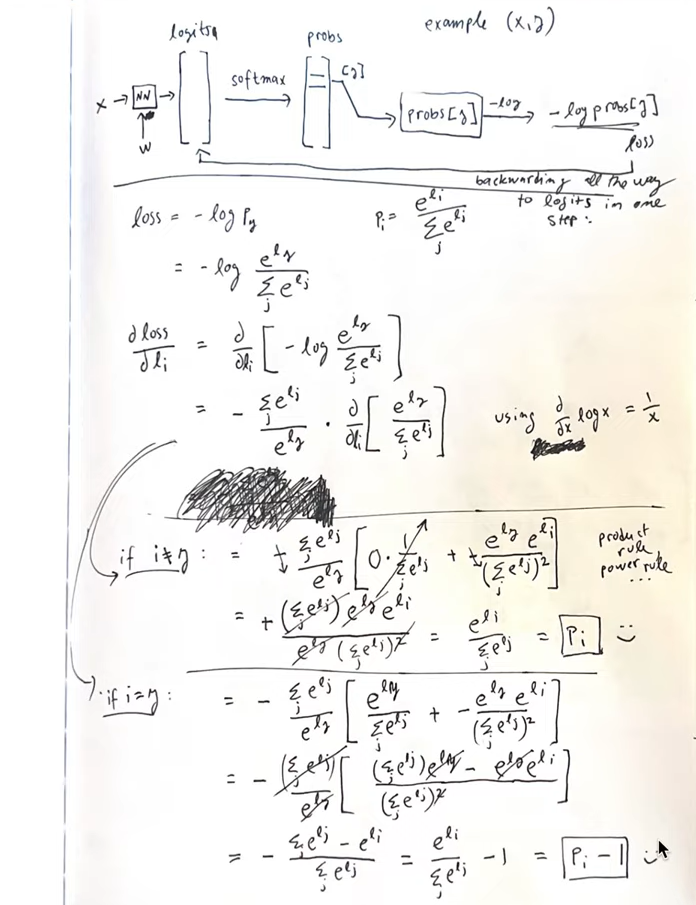

In [323]:
# Backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)  # We can only get approximate to be true. The maxdiff is 6e-9

logits          | exact False | approximate True  | maxdiff 6.05359673500061e-09


In [327]:
logits.shape, Yb.shape

(torch.Size([32, 31]), torch.Size([32]))

In [329]:
F.softmax(logits, 1)[0]

tensor([0.0491, 0.0348, 0.0392, 0.0332, 0.0262, 0.0385, 0.0941, 0.0178, 0.0620,
        0.0137, 0.0628, 0.0056, 0.0229, 0.0062, 0.0425, 0.0539, 0.0208, 0.0240,
        0.0437, 0.0289, 0.0295, 0.0108, 0.0245, 0.0521, 0.0401, 0.0111, 0.0080,
        0.0243, 0.0368, 0.0237, 0.0192], grad_fn=<SelectBackward0>)

In [330]:
dlogits[0] * n

tensor([ 0.0491,  0.0348,  0.0392,  0.0332, -0.9738,  0.0385,  0.0941,  0.0178,
         0.0620,  0.0137,  0.0628,  0.0056,  0.0229,  0.0062,  0.0425,  0.0539,
         0.0208,  0.0240,  0.0437,  0.0289,  0.0295,  0.0108,  0.0245,  0.0521,
         0.0401,  0.0111,  0.0080,  0.0243,  0.0368,  0.0237,  0.0192],
       grad_fn=<MulBackward0>)

We have -1 applied to the 4th position.

In [331]:
dlogits[0].sum()

tensor(-9.3132e-10, grad_fn=<SumBackward0>)

We sum to zero.

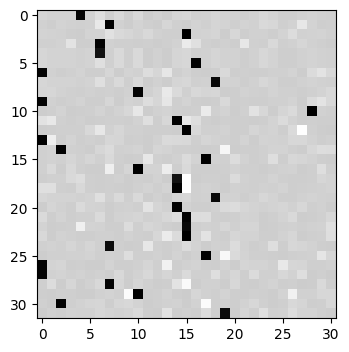

In [325]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray');

dlogits represents the probability matrix of the forward pass. The black indices are the positions for which we subtracted 1.

We can think of dlogits as the pushing/pulling force applied to each character. We modify them (increase/decrease).

# Exercise 3

Backprop through batchnorm but all in one go.

To complete this challenge look at the mathematical expression of the output of batchnorm, take the derivative w.r.t. its input, simplify the expression, and just write it out.

In [332]:
# Forward pass

# Before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# Now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


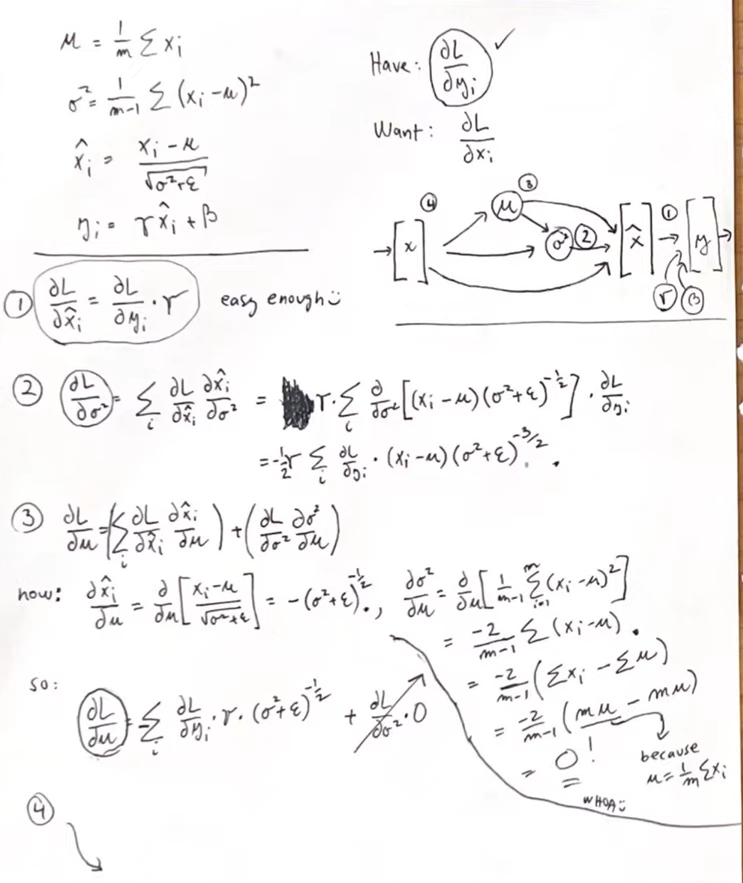

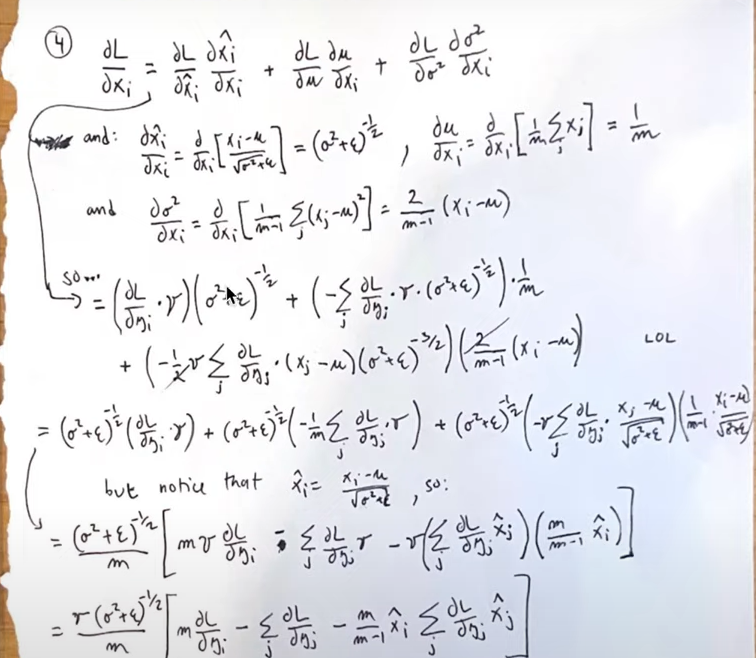

In [334]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# ------------------
# Our code goes here:
# dL/dxi = dL/dxi_bar * dxi_bar/dxi + dL/dmu * dmu/dxi + dL/dsigma^2 * dsigma^2/dxi

# dL/dxi_bar = dL/dyi * dyi/dxi_bar
# dL/dyi --> known
# dyi/dxi_bar = gamma

# dL/dmu --> compute by hand
# dmu/dxi = 1/m

# dL/dsigma^2 --> compute by hand
# dsigma^2/dxi = 2/(m-1) * (xi-mu)

dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn)  # We can only get approximate to be true. Maxdiff is 9e-10

hprebn          | exact False | approximate True  | maxdiff 9.313225746154785e-10


# Exercise 4

Putting it all together: Train the MLP neural net with our own backward pass.

In [ ]:
VOCAB_SIZE = 30 + 1
EMBED_SIZE = 10  # the dimensionality of the character embedding vectors
HIDDEN_SIZE = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(123) # for reproducibility
C  = torch.randn((VOCAB_SIZE, EMBED_SIZE),               generator=g)
# Layer 1
W1 = torch.randn((EMBED_SIZE * block_size, HIDDEN_SIZE), generator=g) * ((5/3) / ((EMBED_SIZE * block_size)**0.5))
b1 = torch.randn(HIDDEN_SIZE,                            generator=g) * 0.1  # it's useless because of BatchNorm, but let's still use it
# Layer 2
W2 = torch.randn((HIDDEN_SIZE, VOCAB_SIZE),              generator=g) * 0.1
b2 = torch.randn(VOCAB_SIZE,                             generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, HIDDEN_SIZE), generator=g) * 0.1 + 1.0
bnbias = torch.randn((1, HIDDEN_SIZE), generator=g) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [336]:
max_steps = 200000
batch_size = 32
lossi = []

# Use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # Kick off optimization
  for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # Forward pass
    emb = C[Xb]  # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # Concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1  # Hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)  # Hidden layer
    logits = h @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swolen_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # Track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #   break

      0/ 200000: 2.8285
  10000/ 200000: 1.4020
  20000/ 200000: 0.9759
  30000/ 200000: 1.5916
  40000/ 200000: 1.1875
  50000/ 200000: 0.8911
  60000/ 200000: 1.2368
  70000/ 200000: 1.5406
  80000/ 200000: 0.9256
  90000/ 200000: 1.1023
 100000/ 200000: 0.8716
 110000/ 200000: 1.0552
 120000/ 200000: 1.0306
 130000/ 200000: 1.0872
 140000/ 200000: 0.9087
 150000/ 200000: 1.0850
 160000/ 200000: 1.2571
 170000/ 200000: 0.9520
 180000/ 200000: 1.0451
 190000/ 200000: 1.4009


In [ ]:
# Useful for checking our gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [ ]:
# Calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # Measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [ ]:
# Evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))